# <font color='darkblue'> Part 3 : Smoking Network Classification using Graph Convolutional Networks</font> 

## Section 4 - Machine Learning for Networks (lead Barry)
- talk introducing ML methods specifically adapted for graphs from first principles
- notebooks covering
 - implementation examples for a couple of GNN model types
 - an example analysis using one of the toy examples
 - a skeleton for analysis of the GenScot network
 
<font color='darkgreen'> Idea so far : </font>

1. From the [EWAS Catalog](https://www.ewascatalog.org/?trait=smoking) get a list of CpG sites and genes relating to smoking
2. Subset to matching CpG sites in the methylation data
3. Swap CpG sites to corresponding Gene (obtained from EWAS)
4. Generate smoking "disease" PPI network from [StringDB](https://string-db.org)
5. Build a data graph dataset which incorporates the Gen Scot methylation data
6. Build a graph classifier which can predict Gen Scot participants who have or have not smoked

<font color='red'> TO DO </font>
1. Incorporate Seb's GNN's
        1.1 Good to get Seb's help & input on this
~~2. Faster baseline implementation -> Logistic Regression CV is too slow~~
3. Improve comments and explain each section
4. Mapping CpG's to genes is not a 1:1 mapping. Genes will be associated with multiple CpG's and vice versa. Need to identify a way better accounts for this
        4.1 Currently aggregating by mean and dropping cpgs with multiple genes
        4.2 Could add extra edges ? 
                4.2.1 Extra edge for two CpG's which are invovled in the same gene
                4.2.3 Add nodes and edges between genes which are impacted by the same CpG
5. Beat Logistic Regression Baseline

<font color='Blue'> Updates </font> <br>
Looks like network needs to be imrpoved. The average node degree is 3 which means that all the relationships are being smoothed out. We want a dense network with meaningful interactions. 
* Have tested with node features for 1 smoker 0 never and got 100% acc -> Model works fine
* Have also test with logistic regression on the node features without a network ~78% accuracy. Small drop off from baseline but close enough
* Began looking at a patient similarity framework too. Can measure similarity based off the smoking phenotypes
    * Accuracy around 65% - improvement but not great
    * potential to use gcn-mme from MOGDx? 
* Also playing around with looking at measuring similarity based off StringDB interactions **np.matmul(PatxGene , PPI)**
    * Similar accuracy
* This again is falling into the smoothing issue where the network has so few interactions that the scores become uniform. Likely what is happening with the graph classification too
* I also added a for loop to the PPI StringDB whereby we now include all genes. The issue with this method is that it assumes genes in seperate for loops do not interact. Probably explains why the degree of the network is so low. 
* Next steps has to look at how we are developing the network and how to best generate this -> Stay with StringDB? 
    * Filtering Network definitely improves performance -> Increasing connectivity is important
    * Might be better to cluster the large network and select biggest cluster?


## <font color='darkblue'>Graph Convolutional Network in the Transductive Setting </font>

In this part we will work with a graph convolutional network. We will attempt to predict whether individuals in the Generation Scotland Dataset have ever smoked. We will work with the network type - patient similarity network whereby we postulate that individuals who have previously smoked will share similar epigenetic markers.

- Formulate the task
- Patient Similarity Network Generation 
- Working with Deep Graph Library
- Building a Graph Convolutional Network 
- Training a GCN 
- Limitations of the Transductive Setting

In [1]:
import pickle
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import sys
sys.path.insert(0 , './../functions.py')

## <font color='darkblue'> Load Data and Network </font>

In [2]:
with open('./../data/GCN_Data.pkl' , 'rb') as file : 
    loaded_data = pd.read_pickle(file)

## <font color='darkblue'> Working with [Deep Graph Library](https://www.dgl.ai/)</font>

In [3]:
import os
os.environ["DGLBACKEND"] = "pytorch"
import dgl
import torch

g = dgl.from_networkx(loaded_data['PSN_EWAS'] , node_attrs=['idx' , 'label'])
g.ndata['feat'] = torch.Tensor(loaded_data['Feat'].iloc[g.ndata['idx'].numpy()].values)

In [4]:
# Sanity Check that our graph is preserved

phenotypes = loaded_data['phenotypes']

node_0 = phenotypes.iloc[g.ndata['idx'].numpy()].iloc[0]

node_0_edges = []
for e1 , e2 in loaded_data['PSN_EWAS'].edges(node_0.name) :  
    node_0_edges.append(e2)
        
# Note : DGL will reorder the nodes if integers present in the node name

sorted(list(phenotypes.iloc[g.ndata['idx'].numpy()].iloc[g.out_edges(0)[1].numpy()].index)) == sorted(node_0_edges)

True

## <font color='darkblue'>Graph Convolutional Network </font>

In [5]:
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import GraphConv
    
class GCN(nn.Module):
    def __init__(self, input_dim,  hidden_feats, num_classes):
        
        super().__init__()
        
        self.gcnlayers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.num_layers = len(hidden_feats) + 1
        
        '''
        #################################################
                       YOUR CODE HERE
        #################################################
        
        '''
        
        for layers in range(self.num_layers) :
            if layers < self.num_layers -1 :
                if layers == 0 : 
                    self.gcnlayers.append(
                        GraphConv(input_dim , hidden_feats[layers])
                    )
                else :
                    self.gcnlayers.append(
                        GraphConv(hidden_feats[layers-1] , hidden_feats[layers])
                    )
                self.batch_norms.append(nn.BatchNorm1d(hidden_feats[layers]))
            else : 
                self.gcnlayers.append(
                    GraphConv(hidden_feats[layers-1] , num_classes)
                )
                
        self.drop = nn.Dropout(0.1)

    def forward(self, g, h):
        # list of hidden representation at each layer (including the input layer)
        
        '''
        #################################################
                       YOUR CODE HERE
        #################################################
        
        We will now perform propagation and aggregation in the same function.
        We need to gather the node features of all neighbouring nodes -> propagation
        We will aggregate these messages by performing median aggregation -> aggregation
        
        Note. This function gathers the messages for a single node and will be useed
        to iterate over in the message_passing_iteration
        
        In this function you will need to : 
            1. Create a nested list of the node features of neighbouring nodes
            2. Aggregate these messages for each node using np.median() or likewise
        '''
        
        for layers in range(self.num_layers) : 
            if layers == self.num_layers - 1 : 
                h = self.gcnlayers[layers](g , h)
            else : 
                h = self.gcnlayers[layers](g, h)
                h = self.drop(F.relu(h))
            
        score = self.drop(h)
            
        return score

### <font color='darkblue'> Training & Evaluation </font>

In [6]:
import torch.optim as optim
import torch.nn as nn
import sklearn as sk
import seaborn as sns
from sklearn.metrics import precision_recall_curve , average_precision_score , recall_score ,  PrecisionRecallDisplay
from tqdm.notebook import tqdm

def train(g, h, train_split , val_split , device ,  model , labels , epochs , lr):
    # loss function, optimizer and scheduler
    loss_fcn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr , weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.8)

    train_loss = []
    val_loss   = []
    train_acc  = []
    val_acc    = []
    
    # training loop
    epoch_progress = tqdm(total=epochs, desc='Loss : ', unit='epoch')
    for epoch in range(epochs):
        model.train()

        logits  = model(g, h)

        loss = loss_fcn(logits[train_split], labels[train_split].float())
        train_loss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        scheduler.step()
        
        if (epoch % 5) == 0 :
            
            _, predicted = torch.max(logits[train_split], 1)
            _, true = torch.max(labels[train_split] , 1)
            train_acc.append((predicted == true).float().mean().item())

            valid_loss , valid_acc , *_ = evaluate(val_split, device, g , h, model , labels)
            val_loss.append(valid_loss.item())
            val_acc.append(valid_acc)
            
            epoch_desc = (
                "Epoch {:05d} | Loss {:.4f} | Train Acc. {:.4f} | Validation Acc. {:.4f} ".format(
                    epoch, np.mean(train_loss[-5:]) , np.mean(train_acc[-5:]), np.mean(val_acc[-5:])
                )
            )
            
            epoch_progress.set_description(epoch_desc)
            epoch_progress.update(5)

    fig1 , ax1 = plt.subplots(figsize=(6,4))
    ax1.plot(train_loss[-1250:]  , label = 'Train Loss')
    ax1.plot(range(5 , len(train_loss[-1250:])+1 , 5) , val_loss[-250:]  , label = 'Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_ylim(0,1)
    ax1.legend()
    
    fig2 , ax2 = plt.subplots(figsize=(6,4))
    ax2.plot(train_acc[-500:]  , label = 'Train Accuracy')
    ax2.plot(val_acc[-500:]  , label = 'Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_ylim(0,1)
    ax2.legend()
    
    # Close tqdm for epochs
    epoch_progress.close()

    return fig1 , fig2

def evaluate(split, device, g , h, model , labels):
    model.eval()
    loss_fcn = nn.CrossEntropyLoss()
    acc = 0
    
    with torch.no_grad() : 
        logits = model(g, h)
        
        loss = loss_fcn(logits[split], labels[split].float())

        _, predicted = torch.max(logits[split], 1)
        _, true = torch.max(labels[split] , 1)
        acc = (predicted == true).float().mean().item()
        
        logits_out = logits[split].cpu().detach().numpy()
        binary_out = (logits_out == logits_out.max(1).reshape(-1,1))*1
        
        labels_out = labels[split].cpu().detach().numpy()
        
        PRC =  average_precision_score(labels_out , binary_out , average="weighted")
        SNS = recall_score(labels_out , binary_out , average="weighted")
        F1 = 2*((PRC*SNS)/(PRC+SNS))
        
    
    return loss , acc , F1 , PRC , SNS

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


GCN(
  (gcnlayers): ModuleList(
    (0): GraphConv(in=23676, out=128, normalization=both, activation=None)
    (1): GraphConv(in=128, out=32, normalization=both, activation=None)
    (2): GraphConv(in=32, out=2, normalization=both, activation=None)
  )
  (batch_norms): ModuleList(
    (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop): Dropout(p=0.1, inplace=False)
)
Graph(num_nodes=1000, num_edges=38886,
      ndata_schemes={'idx': Scheme(shape=(), dtype=torch.int32), 'label': Scheme(shape=(), dtype=torch.int8), 'feat': Scheme(shape=(23676,), dtype=torch.float32)}
      edata_schemes={})


Loss :   0%|          | 0/2000 [00:00<?, ?epoch/s]

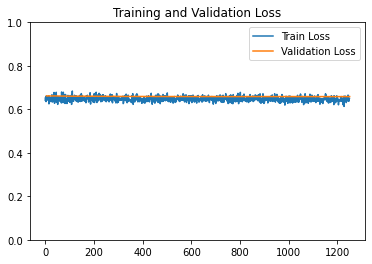

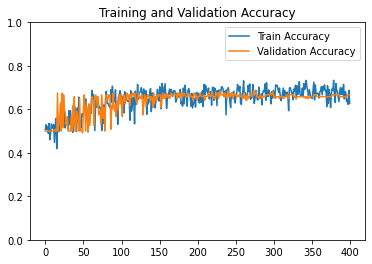

GNN Model | Test Accuracy = 0.7125 | F1 = 0.6816 |


In [7]:
from sklearn.model_selection import train_test_split

device = ('cuda' if torch.cuda.is_available() else 'cpu')

g = g.to(device)

node_subjects = phenotypes['Smoking'].iloc[g.ndata['idx'].detach().cpu().numpy()].reset_index(drop=True) # Get node target labels from meta data
node_subjects.name = 'Smoking'

GCN_input_shapes = g.ndata['feat'].shape[1]

labels = F.one_hot(g.ndata['label'].to(torch.int64))

output_metrics = []
logits = np.array([])
labels_all = np.array([])

train_tmp_index , test_index = train_test_split(
    node_subjects.index, train_size=0.6, stratify=node_subjects
    )
train_index , val_index = train_test_split(
    train_tmp_index, train_size=0.8, stratify=node_subjects.loc[train_tmp_index]
    )

model = GCN(GCN_input_shapes , [128 , 32], len(node_subjects.unique())).to(device) 
print(model)
print(g)

loss_plot = train(g, g.ndata['feat'] , train_index , val_index , device ,  model , labels , 2000 , 1e-3)
plt.show()

test_output_metrics = evaluate(test_index , device , g , g.ndata['feat'] , model , labels )

print(
    "GNN Model | Test Accuracy = {:.4f} | F1 = {:.4f} |".format(
     test_output_metrics[1] , test_output_metrics[2] )
)

In [8]:
from sklearn.linear_model import LogisticRegression

y_vals = labels.detach().cpu().numpy()
input_data = g.ndata['feat'].detach().cpu().numpy()

glmnet = LogisticRegression(penalty='l1' , solver='saga', max_iter = 1000 )
glmnet.fit(input_data[train_index] , y_vals[train_index][: , 0])
glmnet_acc = glmnet.score(input_data[test_index] , y_vals[test_index][: , 0])
print(f'Baseline Logistic Regression ACC : {glmnet_acc}')

Baseline Logistic Regression ACC : 0.79


C:\Users\Barry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
